In [1]:
# 문자열 정비용 모듈
import re       # 파이썬 정규표현식을 이용하여 문자열에서 특정 패턴의 문자열을 매칭하는 기능을 제공
import string   # 문자열 형식으로 출력

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# 데이터 전처리
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For customizing our plots.
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# word clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from collections import defaultdict
import spacy
from spacy.util import compounding
from spacy.util import minibatch

# 자연어처리 패키지
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from tqdm import tqdm
import os

# keras
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

# sklearn 패키지
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

# Loading pytorch packages.
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Loading Electra model packages.
# from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW #Huggingface transformer algorithms and pretrain weights.
#                 #Electra is selected here, its pretraining method is more advanced than BERT's MLM. AdamW is Adam with weight decay correction.
# import torch
# tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator') 
# model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2) #let's try out electra's base discriminator
# model.cuda()

In [2]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xilverh0ya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xilverh0ya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\xilverh0ya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xilverh0ya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xilverh0ya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

In [4]:
#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

### 1. 데이터 적재

In [ ]:
test_df = pd.read_csv("D:/DataSet/Natural Language Processing with Disaster Tweets/test.csv")

test_df.head()

In [79]:
df = pd.read_csv("D:/DataSet/Natural Language Processing with Disaster Tweets/train.csv")

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### 01) 'text_len' Column 생성
- 트윗을 단어 단위로 분리했을 때, 몇개의 단어로 구성되어 있는 지 표시

In [80]:
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df['text_len'].describe()

count    7613.000000
mean       14.928937
std         5.782770
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        54.000000
Name: text_len, dtype: float64

In [81]:
max(df['text_len'])

54

### 2. EDA와 전처리

#### 01) 타겟값의 균형성 확인

In [82]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271], dtype=int64)

In [83]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham(1)'],
    y=[balance_counts[0]],
    name='ham(1)',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam(0)'],
    y=[balance_counts[1]],
    name='spam(0)',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

* spam > ham : 1071개 차이

#### 02) 텍스트 정리(Cleaning Text)

- 각종 함수를 통해 정제하기 전, 간단한 전처리를 통해 '깔끔한' 텍스트로 변환한다.  
<br>
    - urls, emojis, html tags, punctuations 등 삭제

```
punctuations(구두점) : 
 마침표(.), 컴마(,), 물음표(?), 세미콜론(;), 느낌표(!) 등과 같은 기호
```

In [11]:
# url 제거
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# 이모지 제거
# re.compile :  정규 표현식(text)을 컴파일
def remove_emoji(text):
  emoji_pattern = re.compile(
      '['
      u'\U0001F600-\U0001F64F'  # emoticons
      u'\U0001F300-\U0001F5FF'  # symbols & pictographs
      u'\U0001F680-\U0001F6FF'  # transport & map symbols
      u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
      u'\U00002702-\U000027B0'
      u'\U000024C2-\U0001F251'
      ']+',
      flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

#html 제거
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# punctuation 제거
# str.maketrans('원래 문자', '대입할 문자', '제외할 문자')
# len(원래 문자) = len(대입할 문자)
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

- 오타 검수

In [84]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)        
    return " ".join(corrected_text)

test = 'eartuake here'
correct_spellings(test)

'earthquake here'

In [85]:
# 위의 함수를 lambda를 이용하여 대입

df['text_clean'] = df['text'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_emoji(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))
df['text_clean'] = df['text_clean'].apply(lambda x: correct_spellings(x))
df['text_clean'] = df['text_clean'].apply(lambda x: x.lower())
df.head()

,id,keyword,location,text,target,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,just got sent this photo from ruby alaska as s...


- Stopwords(불용어) 제거  
    <br>
    - Stopword는 문장에서 문맥적 의미가 없는 영어에서 일반적으로 사용되는 단어입니다.  
    <br>
    - 분류 전에 제거

In [86]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['text_clean'] = df['text_clean'].apply(remove_stopwords)
df.head()

,id,keyword,location,text,target,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo ruby alaska smoke wildfires pou...


#### 03) 형태소 분석 / 표제어화 (Stemming / Lematization)  

##### 형태소 분석(Stemming)

In [87]:
# Stemming
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [88]:
df['text_clean'] = df['text_clean'].apply(stemm_text)
df.head()

,id,keyword,location,text,target,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,13000 peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


##### 표제어화 사전 준비

- 토큰화(Tokenized)  
<br>
    - 텍스트를 단어 단위로 분리하는 것.  
    <br>
    - Ex) Input : Time is an illusion. Lunchtime double so!
    - Output : "Time", "is", "an", "illustion", "Lunchtime", "double", "so" 

In [89]:
df['tokenized'] = df['text_clean'].apply(word_tokenize)

df.head()

,id,keyword,location,text,target,text_len,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us,"[deed, reason, earthquak, may, allah, forgiv, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada,"[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...,"[resid, ask, shelter, place, notifi, offic, ev..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,13000 peopl receiv wildfir evacu order california,"[13000, peopl, receiv, wildfir, evacu, order, ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...,"[got, sent, photo, rubi, alaska, smoke, wildfi..."


- 품사 태깅 적용  
<br>
    - 단어에 품사를 태그하여 튜플형태로 반환  -> 표제어화(Lematizaion)를 위함

```py
ex) 
입력 :  "I am actively looking for Ph.D. students. and you are a Ph.D. student."

출력 :  [('I', 'PRP'), ('am', 'VBP'), ('actively', 'RB'), ('looking', 'VBG'), ('for', 'IN'), ('Ph.D.', 'NNP'), ('students', 'NNS'), ('.', '.'), ('and', 'CC'), ('you', 'PRP'), ('are', 'VBP'), ('a', 'DT'), ('Ph.D.', 'NNP'), ('student', 'NN'), ('.', '.')]
```

    - PRP: 인칭 대명사
    - VBP: 동사
    - RB : 부사
    - VBG : 현재부사
    - IN : 전치사
    - NNP : 고유 명사
    - NNS : 복수형 명사
    - CC : 접속사
    - DT : 관사

In [90]:
df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

df.head()

,id,keyword,location,text,target,text_len,text_clean,tokenized,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us,"[deed, reason, earthquak, may, allah, forgiv, us]","[(deed, NN), (reason, NN), (earthquak, NN), (m..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada,"[forest, fire, near, la, rong, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, N..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...,"[resid, ask, shelter, place, notifi, offic, ev...","[(resid, NN), (ask, NN), (shelter, NN), (place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,13000 peopl receiv wildfir evacu order california,"[13000, peopl, receiv, wildfir, evacu, order, ...","[(13000, CD), (peopl, JJ), (receiv, NN), (wild..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...,"[got, sent, photo, rubi, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (rubi, N..."


- 품사 태그 문어체화  
<br>
    - 기존 구어체 형태의 태그를 사전에서 표시하는 형태와 같은 문어체 형태로 변환

In [91]:
def get_wordnet_pos(tag) :
  if tag.startswith('J') :
    return wordnet.ADJ
  elif tag.startswith('V') :
    return wordnet.VERB
  elif tag.startswith('N') :
    return wordnet.NOUN
  elif tag.startswith('R') :
    return wordnet.ADV
  else :
    return wordnet.NOUN

df['wordnet_pos'] = df['pos_tags'].apply(
    lambda x : [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

df.head()

,id,keyword,location,text,target,text_len,text_clean,tokenized,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us,"[deed, reason, earthquak, may, allah, forgiv, us]","[(deed, NN), (reason, NN), (earthquak, NN), (m...","[(deed, n), (reason, n), (earthquak, n), (may,..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada,"[forest, fire, near, la, rong, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, N...","[(forest, a), (fire, n), (near, n), (la, n), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...,"[resid, ask, shelter, place, notifi, offic, ev...","[(resid, NN), (ask, NN), (shelter, NN), (place...","[(resid, n), (ask, n), (shelter, n), (place, n..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,13000 peopl receiv wildfir evacu order california,"[13000, peopl, receiv, wildfir, evacu, order, ...","[(13000, CD), (peopl, JJ), (receiv, NN), (wild...","[(13000, n), (peopl, a), (receiv, n), (wildfir..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...,"[got, sent, photo, rubi, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (rubi, N...","[(got, v), (sent, a), (photo, n), (rubi, n), (..."


##### 표제어화(Lemmatization)

- 같은 의미지만 다른 형태를 띄는 단어들 존재  
<br>
    - 문법 상의 이유로 사용되는 다양한 형태의 단어.   
        - Ex) write / writing / writes , be / is / are  
        <br>
    - 이러한 이유로 형태소 분석과 표제어화 필요  
        - 목적 : 다양한 형태의 텍스트를 공통 기본 형태로 줄이는 것.  
        <br>
- 형태소 분석 (Stemming) : 일반적으로 단어의 끝을 잘라내는 과정, 종종 파생 접사 제거를 포함  
<br>
- 표제어화(Lematiazion) : 단어의 형태학적 파싱을 먼저 진행, 어간과 접사를 분리  

In [92]:
# Lemmatization
wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

df.head()

,id,keyword,location,text,target,text_len,text_clean,tokenized,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us,"[deed, reason, earthquak, may, allah, forgiv, us]","[(deed, NN), (reason, NN), (earthquak, NN), (m...","[(deed, n), (reason, n), (earthquak, n), (may,...","[deed, reason, earthquak, may, allah, forgiv, u]",deed reason earthquak may allah forgiv u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada,"[forest, fire, near, la, rong, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, N...","[(forest, a), (fire, n), (near, n), (la, n), (...","[forest, fire, near, la, rong, sask, canada]",forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...,"[resid, ask, shelter, place, notifi, offic, ev...","[(resid, NN), (ask, NN), (shelter, NN), (place...","[(resid, n), (ask, n), (shelter, n), (place, n...","[resid, ask, shelter, place, notifi, offic, ev...",resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,13000 peopl receiv wildfir evacu order california,"[13000, peopl, receiv, wildfir, evacu, order, ...","[(13000, CD), (peopl, JJ), (receiv, NN), (wild...","[(13000, n), (peopl, a), (receiv, n), (wildfir...","[13000, peopl, receiv, wildfir, evacu, order, ...",13000 peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...,"[got, sent, photo, rubi, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (rubi, N...","[(got, v), (sent, a), (photo, n), (rubi, n), (...","[get, sent, photo, rubi, alaska, smoke, wildfi...",get sent photo rubi alaska smoke wildfir pour ...


#### 04) 시각화(Visualization)

##### 1. 타켓층 분포도 확인
- 1 : 재난 관련 트윗('Disaster')
- 2 : 페이크('Fake')

In [93]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [94]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271], dtype=int64)

In [95]:
# 타겟분포도 (기본)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

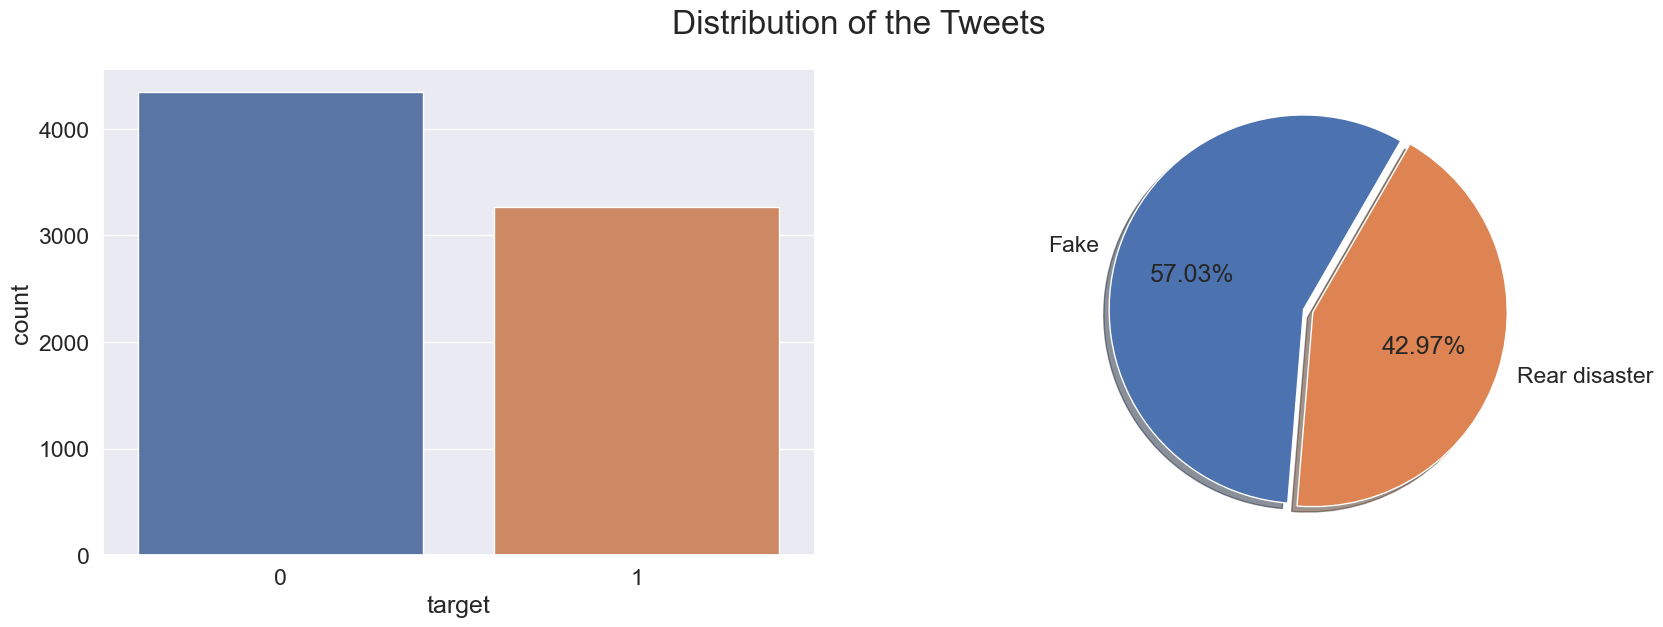

In [96]:
# 타겟 분포도 카운트 플롯, 파이프롯으로 그려보기(퍼센테이지 표시)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(df['target'], ax=axes[0])
axes[1].pie(df['target'].value_counts(),
            labels=['Fake', 'Rear disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [97]:
disaster_df = df[df['target'] == 1]['text_len'].value_counts().sort_index()
fake_df = df[df['target'] == 0]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=disaster_df.index,
    y=disaster_df.values,
    name='Real disaster',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=fake_df.index,
    y=fake_df.values,
    name='Fake',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.show()

* Fake(0) > Real disaster(1) : 1071개 차이

##### 2. 재해와 트윗 길이의 연관성

- 트윗 길이와 재난 관련 트윗의 상관관계 분석  

In [98]:
# punctuation 등을 제거한 텍스트의 길이 구하기
df['Tweet Length'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # 작성자만의 cudtomize chart 만들기
    # constrained_layout = True: 서브 플롯 간의 간격을 겹치지 않게 최적의 수치로 자동 조정
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # (3,3)으로 구성된 그리드 만들기
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # 히스토그램 커스터마이징하기
    ax1 = fig.add_subplot(grid[0, :2])
    # 표의 타이틀
    ax1.set_title('Histogram')
    # 히스토그램 그리기
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,             # kde=True : 커널 밀도 함수 곡선을 그리기
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    # xaxis.set_major_locator : 축에 간격을 구분하기 위해 표시하는 눈금을 nbins의 최대 빈수로
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # 경험적 누적분포 함수 그리기
    ax2 = fig.add_subplot(grid[1, :2])
    # 표 타이틀
    ax2.set_title('Empirical CDF')
    # 누적분포 그리기
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},   # kde_kws={'cumulative': True} : 
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability') # 누적 확률

    # 박스 플롯 그리기
    ax3 = fig.add_subplot(grid[:, 2])
    # 타이틀 정하기
    ax3.set_title('Box Plot')
    # 박스플롯 그리기
    sns.boxplot(y=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

- Fake(0)의 트윗 길이 그래프

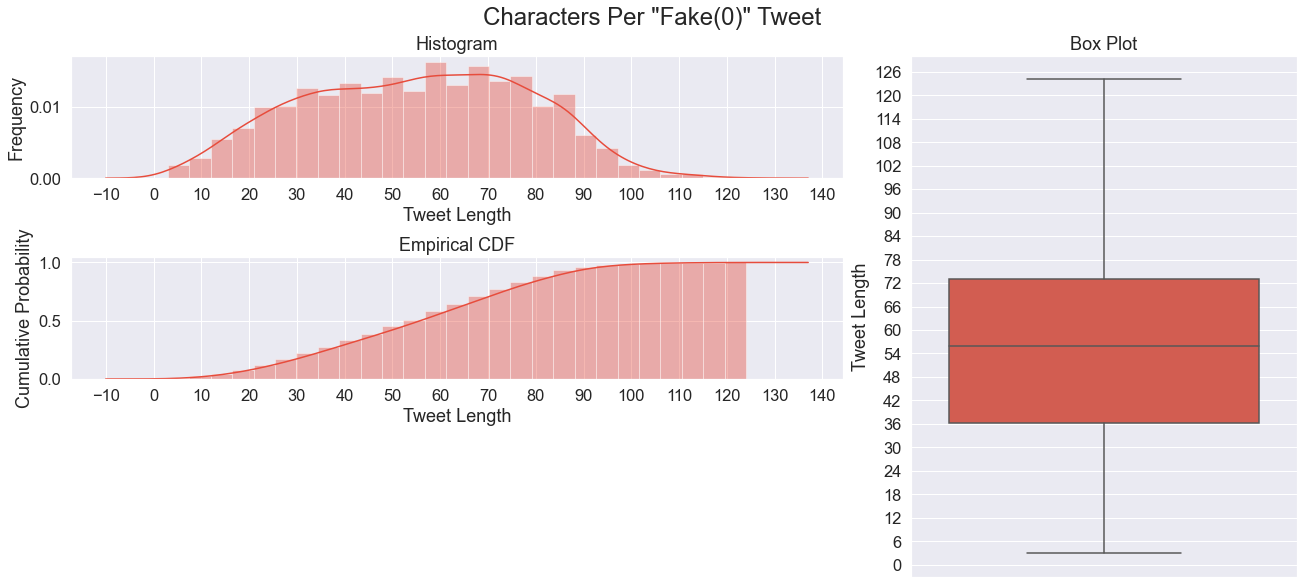

In [99]:
plot_dist3(df[df['target'] == 0], 'Tweet Length',  'Characters Per "Fake(0)" Tweet')

> - 평균 트윗 길이 : 36 ~ 72

- Real disaster(1)의 트윗 길이 그래프

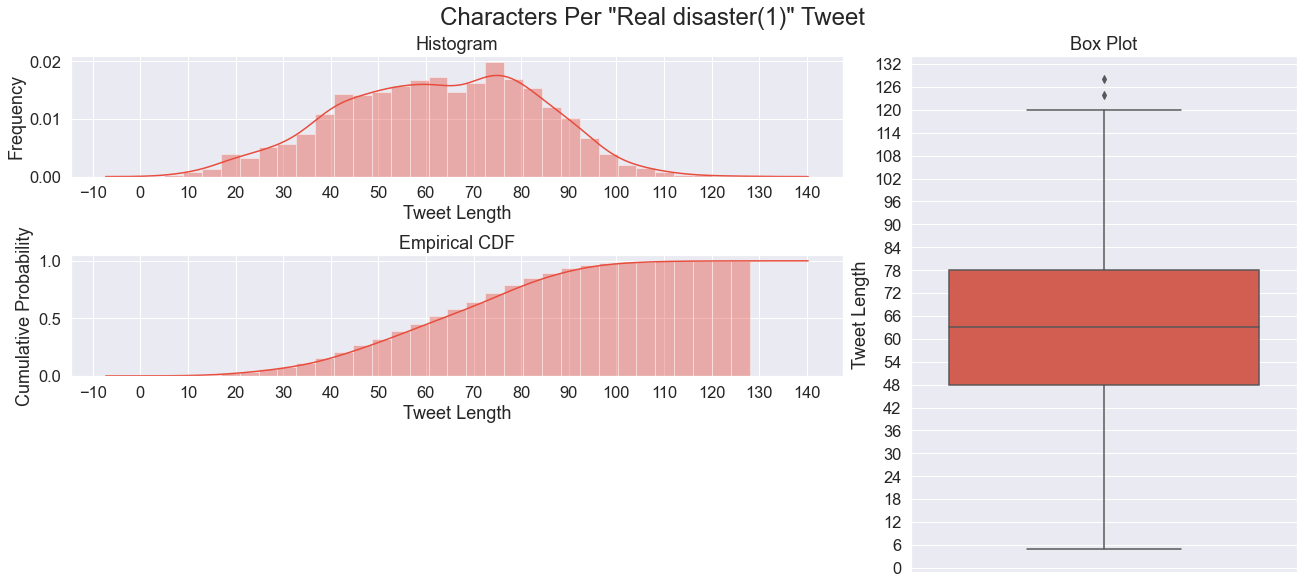

In [100]:
plot_dist3(df[df["target"] == 1], 'Tweet Length',  'Characters Per "Real disaster(1)" Tweet')

> - 평균 트윗 길이 : 48 ~ 78

평균적으로 실제 재난과 관련이 있는 트윗의 길이가 근소하게 더 긴 모습

##### 3. 재해와 트윗 단어 수의 연관성

- 2-04-2을 바탕으로 재해와 트윗 길이가 어느정도 연관성을 지니는 것을 확인  
<br>
    - 단순 길이와만 연관성이 있는 지, 단어의 수와도 비교

In [101]:
def plot_word_number_histogram(textno, textye):
    
    # word count 비교

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    # sharey=True : x축과 y축 공유하기
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Fake Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Real disaster Tweets')
    
    #  va='baseline' : x,y의 값을 아래에
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout() # axes의 간격 적절하게 조절

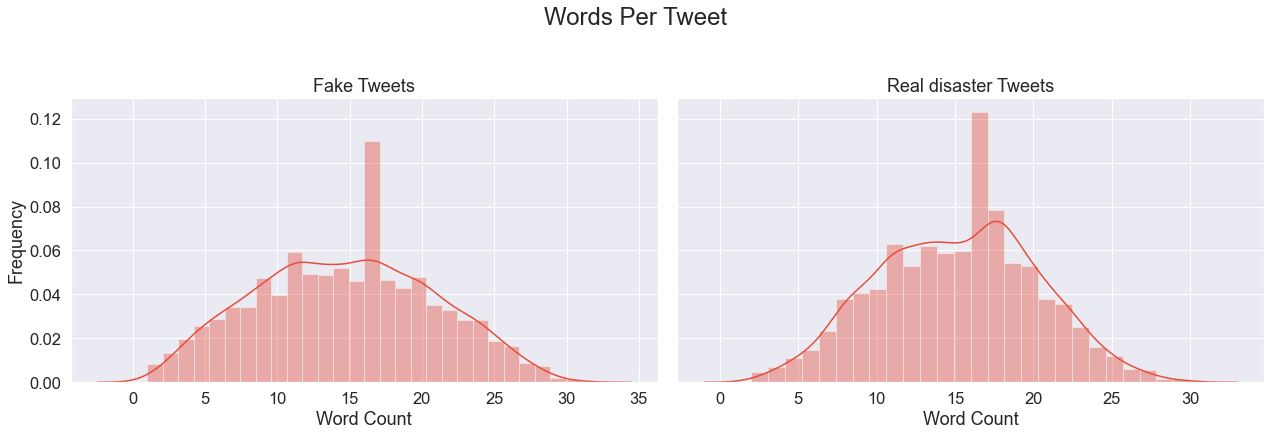

In [102]:
plot_word_number_histogram(df[df['target'] == 0]['text'],
                          df[df['target'] == 1]['text'])

> - 역시나 재해 관련 트윗의 단어 갯수가 근소하게 많음
> - 이 정도의 차이를 고려할 필요가 있을까?에 대해 팀원들과 토의가 필요

##### 4. 가장 많이 사용된 단어

- 상황에 따라 일반적으로 쓰이는 단어가 달라, 재난 관련 트윗과 일반 트윗도 차이가 있을것으로 예상  
<br>
    - CountVertorizer를 사용하여 단어 출현 빈도 계산  
<br>
        - 단어의 빈도를 count하여 vector로 만드는 사이킷런의 클래스  
    <br>
        - 기본적으로 문자의 길이가 2 이상인 문자에 대해서만 토큰으로 인식  
    <br>
        - 길이가 짧은 문자를 제거하는 것 또한 전처리 작업 중 일부  
    <br>
        - 띄어쓰기를 기준으로 단어를 잘라 낮은 수준의 토큰화 진행  
    <br>
        - 한국어에 적용하면 조사 등의 이유로 BoW가 제대로 만들어지지 않음  
    <br>

In [103]:
# 단어의 평균 길이 확인하는 함수
def plot_word_len_histogram(textno, textye):
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Fake Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Real disaster Tweets')
    
    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()

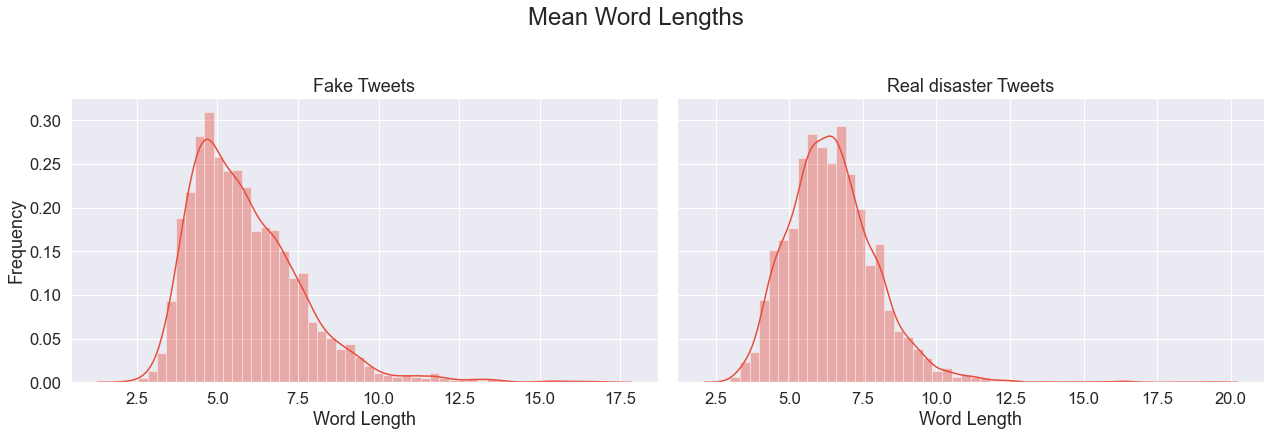

In [104]:
plot_word_len_histogram(df[df['target'] == 0]['text'],
                        df[df['target'] == 1]['text'])

> - 사용된 단어의 평균적 길이 : 일반 트윗 < 재해 관련 트윗

- 최다 빈출 단어 시각화 전 데이터로 먼저 확인

In [105]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target'] == target]['text_clean'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [106]:
corpus_disaster_tweets = create_corpus_df(df, 1)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('fire', 267),
 ('bomb', 181),
 ('kill', 158),
 ('news', 137),
 ('flood', 121),
 ('via', 121),
 ('disast', 118),
 ('california', 115),
 ('crash', 113),
 ('suicid', 110)]

In [107]:
corpus_fake_tweets = create_corpus_df(df, 0)

dic=defaultdict(int)
for word in corpus_fake_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 308),
 ('get', 223),
 ('new', 168),
 ('go', 143),
 ('dont', 142),
 ('one', 136),
 ('love', 118),
 ('bodi', 116),
 ('bag', 109),
 ('time', 105)]

- 최다 빈출 단어 시각화

In [108]:
# 표제어 추출 따로 묶기
lis = [
       df[df['target'] == 0]['lemma_str'],
       df[df['target'] == 1]['lemma_str']
]

In [109]:
# 확인하기
lis

[15                                                    man
 16                                             love fruit
 17                                            summer love
 18                                               car fast
 19                                        goooooooaaaaaal
                               ...                        
 7581    engin great atmospher british lion gig tonight...
 7582           cramer iger 3 word wreck disney stock cnbc
 7584    box readi explod explod kitten final arriv gam...
 7587                                      siren everywher
 7593          heard realli loud bang everyon asleep great
 Name: lemma_str, Length: 4342, dtype: object,
 0                deed reason earthquak may allah forgiv u
 1                    forest fire near la rong sask canada
 2       resid ask shelter place notifi offic evacu she...
 3       13000 peopl receiv wildfir evacu order california
 4       get sent photo rubi alaska smoke wildfir pour ...
         

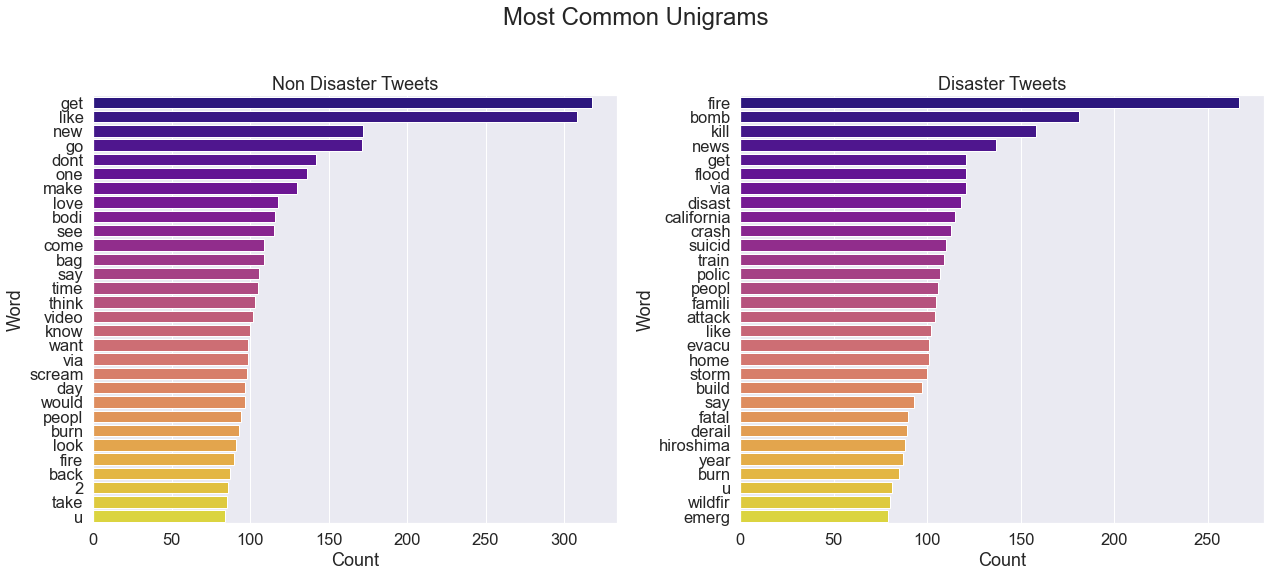

In [110]:
# 가장 많이 쓰인 단어

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist() # 데이터프레임을 목록으로 변환
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common() # 가장 많이 쓰이는 단어
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

> <br>

> - 재난 트윗 fire, kill, bomb...  
> <br>
> - 일반 트윗 = 일반적으로 쓰이는 단어  
> <br>

In [111]:
# 가장 많이 쓰인 둘 이상의 단어를 ngram을 통해 분석

def ngrams(n, title):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()   # 데이터프레임을 목록으로 변환
        corpus = [word for i in new for word in i]

        # top_ngram
        # CountVectorizer 사용
        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()] # vec.vocabulary_ : 단어의 인덱스 부여
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Fake Tweets')
        axes[1].set_title('Real disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

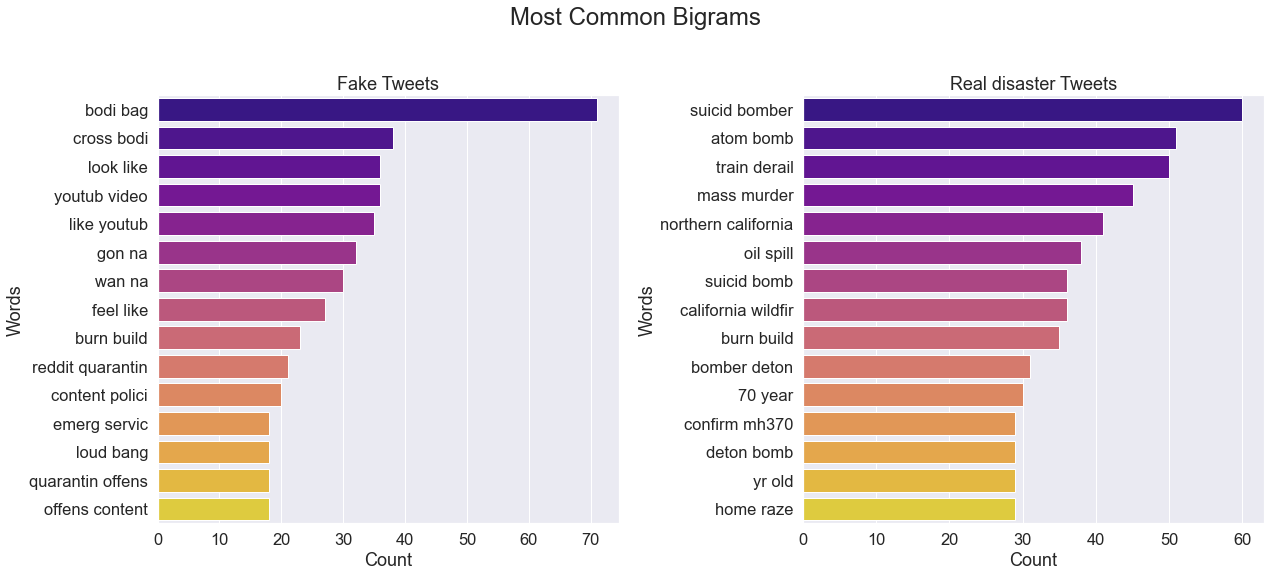

In [112]:
ngrams(2, "Most Common Bigrams")

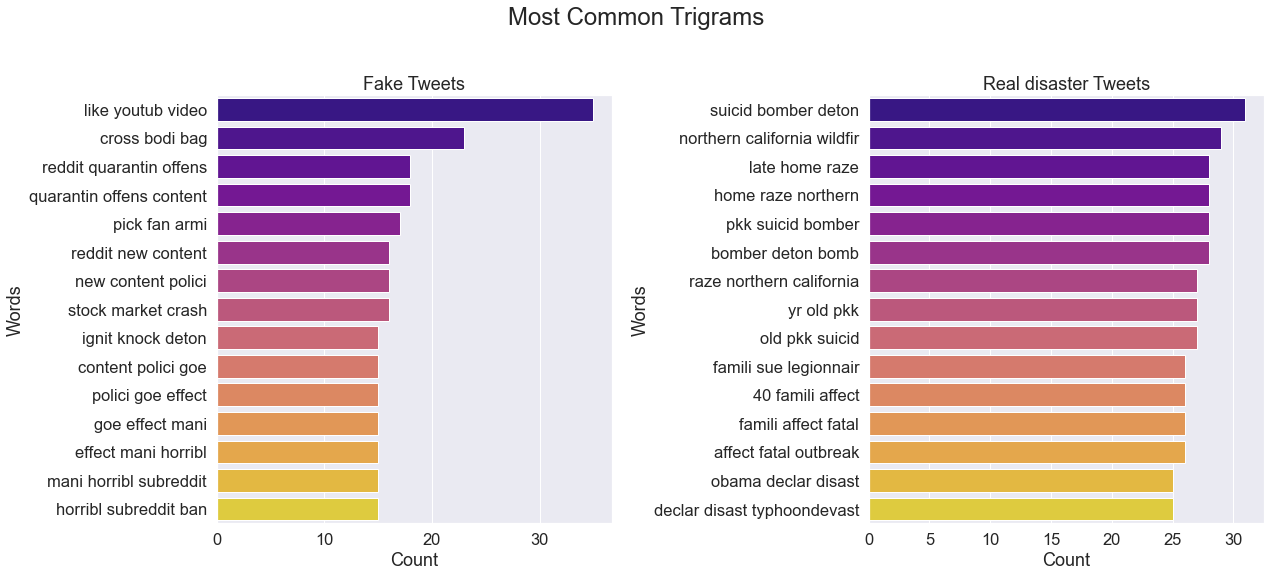

In [113]:
ngrams(3, "Most Common Trigrams")

##### 5. 다른 시각화 모델 활용

- Word Cloud

In [114]:
mask = np.array(Image.open('./asset/wordcloud_mask/twitter_mask.png'))
mask[mask.sum(axis = 2) == 0] = 255

In [115]:
# mask[mask.sum(axis = 2) == 0] = 255 가 작동하지 않을 때 사용
# for i in range(len(mask)):
#     for j in range(len(mask[i])):
#         if mask[i][j]==0:
#             mask[i][j] = 255

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width = 1200,
        height = 800,
        background_color = 'black',
        stopwords = set(STOPWORDS),
        max_words = 150,
        scale = 3,
        mask = mask,
        contour_width = 0.1,
        contour_color = 'grey',
    ).generate(str(mostcommon))    

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
df[df['target'] == 1]['lemmatized'].count()

3271

In [ ]:
df[df['target'] == 0]['lemmatized'].count()

4342

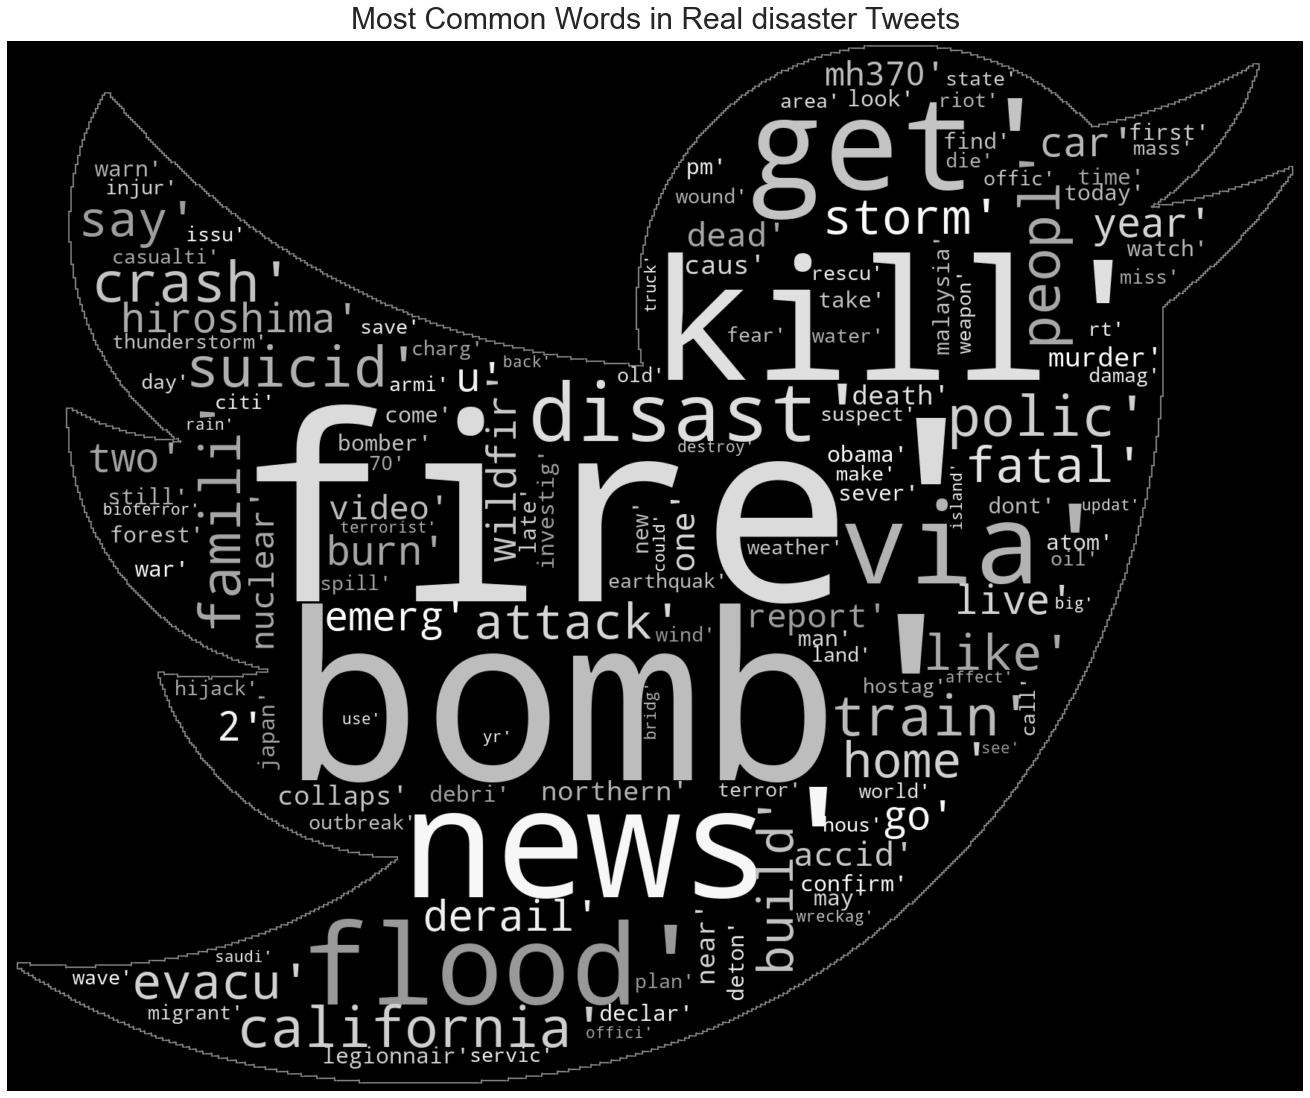

In [116]:
plot_wordcloud(df[df['target'] == 1]['lemmatized'],
               'Most Common Words in Real disaster Tweets',
               title_size=30)

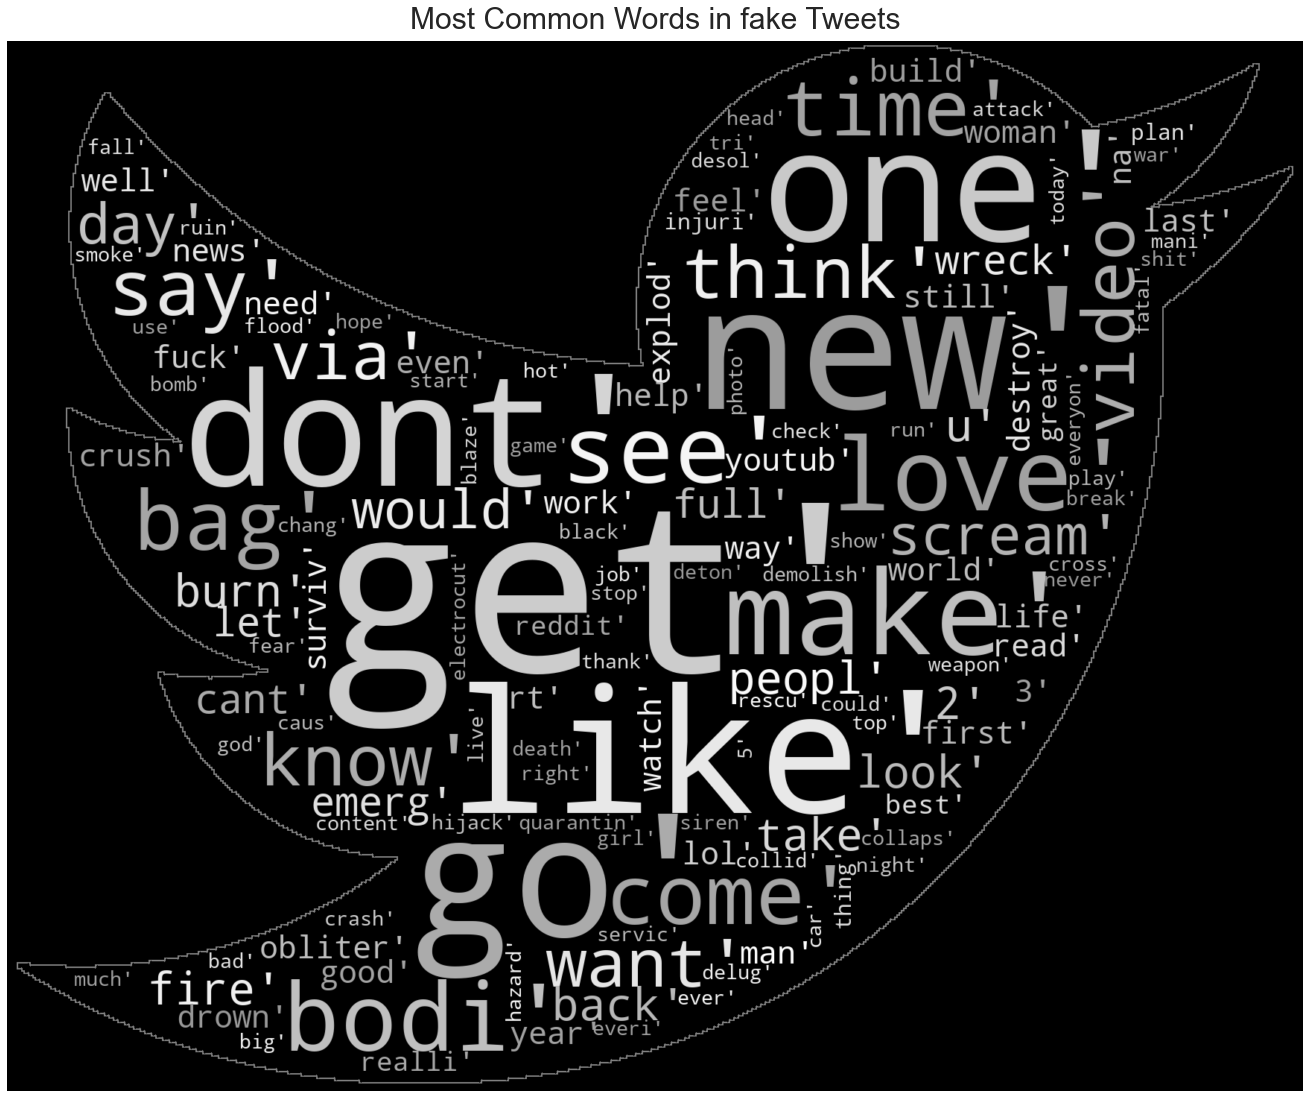

In [117]:
plot_wordcloud(df[df['target'] == 0]['lemmatized'],
               'Most Common Words in fake Tweets',
               title_size=30)

In [118]:
corpus_disaster_tweets = create_corpus_df(df, 1)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('fire', 267),
 ('bomb', 181),
 ('kill', 158),
 ('news', 137),
 ('flood', 121),
 ('via', 121),
 ('disast', 118),
 ('california', 115),
 ('crash', 113),
 ('suicid', 110)]

### 3. 벡터화

- SciKitLearn의 모델이 작동할 수 있도록 벡터로 변환  
<br>
- 1. TF(Term Frequency) 계산  
<br>
- 2. IDF(Inverse Document Frequency) 적용  
<br>
- 3. 정규화 : 벡터를 단위 길이로 정규화  
    - L2 Norm에서 추상화  
        - L2 Norm : 유클리드 좌표계

- 각각의 벡터는 많은 차원을 갖는다.  

In [119]:
# CountVectorizer를 사용하기 위해 x축과 y축을 정의
x = df['text_clean']
y = df['target']

print(len(x), len(y))

7613 7613


- 트레인셋과 테스트셋 분리

In [120]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


- SciKit Learn의 CountVectorizer를 사용하여 텍스트 문서들을 토큰 수의 매트릭스로 변환

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer() # 벡터라이저 인스턴스화
vect.fit(x_train)

CountVectorizer()

- 훈련 및 테스트 세트에서 문서 단어 행렬(DTM, Document-Term Matrix) 생성  
<br>
    - 문서 단어 행렬(DTM, Document-Term Matrix) : 다수의 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현

In [122]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

##### 01) CountVectorizer 튜닝  

- CountVectorizer에는 필수적으로 알아야 할 매개변수들이 존재  
<br>
- 1. stop_words : CountVectorizer는 텍스트에서 각 단어의 갯수만을 헤아리기 때문에 의미없이 반복되는 단어들의 중요도를 높이 평가.
Ex) '그리고', '또' ... etc  
<br>
    - 이를 해결하기 위해 stop_words = 'english' 사용을 통해 의미없이 자주 사용되는 단어들을 제거 (Default = None)  
<br>
- 2. ngram_range : ngram_range(a, b)를 통해 최소값(a), 최대값(b) 조정  
<br>
    - n-그램은 단어장 생성에 사용할 토큰의 크기를 결정한다. 
    모노그램(1-그램)은 토큰 하나만 단어로 사용하며, 
    바이그램(2-그램)은 두 개의 연결된 토큰을 하나의 단어로 사용  
    - Default : ngram_range(1, 1)  
    - TMI : 최근 '온라인 채용 공고 모델링'프로젝트에서 Bigram(2-gram)을 적용한 모델의 예측력이 향상됐다는 결과('Data Scientist', 'Data Engineer'와 같이 '직함'은 대부분 2 단어로 구성)    
<br>
- 3. min_df, max_df : 단어나 n-gram이 최소/최대 몇 번이나 기능으로써 작용해야 하는 지 정하는 매개변수. max_df, min_df 인수를 사용하여 문서에서 토큰이 나타난 횟수를 기준으로 단어장을 구성.    
<br>
    - min_df : 최소 몇개 문서에 걸쳐 포함된 단어를 단어 꾸러미에 담아 사용할 것인지 **단어장에 포함되기 위한 최소 빈도**  
    - max_df : 최대 어느 정도의 비중을 가진 단어를 단어 꾸러미에 담아 사용할 것인지 **단어장에 포함되기 위한 최대 비중**  
    - 토큰의 빈도가 max_df로 지정한 값을 초과 하거나 min_df로 지정한 값보다 작은 경우에는 무시  
    - 인수 값은 정수인 경우 **횟수**, 부동소수점인 경우 **비중**을 뜻한다.  
    <br>
    - Default(min_df) : 1(int)  
    - Default(min_df) : 1.0(float)  
<br>
- 4. max_features : 텍스트에서 가장 자주 출현하는 단어/기능을 선택하고 나머지 삭제(최고 빈도 단어만 고려)  

In [123]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

##### 02) TD-IDF

- 말뭉치(Corpus)의 문서에서 단어가 얼마나 중요한지를 반영하기 위한 수치 통계  
<br>
    - 정보 검색, 텍스트 마이닝 및 사용자 모델링 검색에서 가중치로 사용  
    - 일부 단어가 일반적으로 더 자주 나타나는 사실을 조정  

In [124]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<5709x11852 sparse matrix of type '<class 'numpy.float64'>'
	with 51016 stored elements in Compressed Sparse Row format>

##### 03) GloVe : Word Embeddings

- 텍스트를 컴퓨터가 이해하고, 효율적으로 처리하게 하기 위해 컴퓨터가 이해할 수 있도록 텍스트를 적절한 숫자로 변환이 필요  
<br>
    - 그 전에 숫자로 변환하기 쉽도록 토큰화를 진행  

In [125]:
texts = df['text_clean']
target = df['target']

In [126]:
# '어휘' 길이 계산
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

14377

- [Pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)  
<br>
    - 시퀀스(정수 리스트)의 리스트(```num_samples```의 길이)을 (```num_samples```, ```num_timesteps```)의 2D Numpy 배열의 형태로 변환  
    <br>
    -  ```num_timesteps```는 제공된 경우 maxlen 인수이거나 목록에서 가장 긴 시퀀스의 길이입니다.

In [127]:
# Look up Error 발생으로 인해 punkt 설치 코드 추가
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xilverh0ya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [128]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[3823,  471,  216, ...,    0,    0,    0],
       [ 142,    2,  109, ...,    0,    0,    0],
       [1404,  433, 1890, ...,    0,    0,    0],
       ...,
       [2872, 3817, 5476, ...,    0,    0,    0],
       [  29,  173, 2701, ...,    0,    0,    0],
       [ 177,   30,  432, ...,    0,    0,    0]])

- 워드 임베딩(Word Embedding)  
<br>
    - 기본적으로 언어에 대한 인간의 이해를 기계의 이해로 연결하는 단어 표현의 한 형태  
    <br>
    - 단어를 밀집 벡터(Dense Vector)의 형태로 표현하는 방법  
    <br> 
    - 단어 임베딩을 사용하면 모든 개별 단어는 사전에 정의된 벡터 공간에서 실수 벡터로 표현  
    <br>
    - 각 단어는 하나의 벡터에 매핑, 벡터값은 신경망과 유사한 방식으로 학습  
    <br>
    - 임베딩 벡터(Embedding Vector) : 워드 임베딩의 산출물  
    <br> 
        - LSA, Word2Vec, FastText, Glove 등 존재  
        <br> 
        - Keras에서 제공하는 Embedding() : 단어를 랜덤한 값을 가지는 밀집 벡터로 변환한 뒤, 인공 신명망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습하는 방법 사용  
        <br> 
        - 두 개의 유사한 단어가 벡터 공간에 매우 밀접하게 배치된 경우, 거의 유사한 벡터로 표현(의미를 고려)  
        <br><br> 
- GloVe (Global Vectors for Word Representation)  
<br>
    - 단어 표현을 위한 전역 벡터 알고리즘  
    <br>
    - 단어에 대한 벡터 표현을 얻기 위한 비지도 학습 알고리즘  
    <br>
    - 전체 말뭉치(Corpus)에서 동시 발생한 단어에 중점  
    <br>
    - 동시 발생 매트릭스에서 **단어 간 의미 관계** 도출 가능  
    <br>
    - LSA와 Word2Vec의 단점을 극복하고 두 방법론을 모두 사용
        - LSA : Corpus의 전체적인 통계 정보 고려, 단어 의미 유추에서 성능 저하  
        <br>
        - Word2Vec : 예측기반으로 단어 의미 유추에서 뛰어난 성능, 임베딩 벡터가 윈도우 크기 내에서만 주변 단어를 고려하기 때문에 Corpus의 전체적인 통계 정보 반영 불가


In [129]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('C:/MyStudy/06_Mini_Project/Kaggle_02_Narutal Language Processing with Disaster Tweets/asset/glove_6B_100d/glove.6B.100d.txt', encoding = 'utf-8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [130]:
# GloVe 딕셔너리에 있는 단어의 임베딩 벡터 로드
# 나머지는 0으로 초기화
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [-0.02098   ,  0.48956999,  0.16098   , ...,  0.21093   ,
         0.10378   ,  0.14366999],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

### 4. 모델링

In [131]:
import plotly.figure_factory as ff

x_axes = ['Ham(1)', 'Spam(0)']
y_axes =  ['Spam(0)', 'Ham(1)']

def conf_matrix(z, x = x_axes, y = y_axes):
    
    z = np.flip(z, 0)

    # z의 각 요소를 주석에 대한 유형 문자열로 변경
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title = 'Predicted value'),
                      yaxis = dict(title = 'Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [132]:
# 다항분포 나이브 베이즈 모델
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

#### 1) Naive Bayes DTM
- **베이즈 정리**에 기초  

In [133]:
# 예측 모델 생성
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [134]:
# 모델의 예측 정확도
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.8040966386554622


##### 1. ROC Curve와 AUC
- ROC (Receiver Operating Characteristic) curve : FPR과 TPR을 각각 x, y축으로 놓은 그래프  
<br>
    - TPR (True Positive Rate): 1인 케이스에 대해 1로 바르게 예측하는 비율 (Sensitivity), 재난 트윗에 대해 위험이라고 진단  
    <br>
    - FPR (False positive rate): 0인 케이스에 대해 1로 틀리게 예측하는 비율 (1 - Specificity), 스팸 트윗에 대해 위험이라고 진단  
    <br>
- AUC (Area Under the ROC Curve) : ROC curve의 밑면적  
<br>
    - 성능 평가에 있어서 수치적인 기준  
    <br>
    - 1에 가까울수록 좋은 모델  

In [135]:
# AUC 계산
metrics.roc_auc_score(y_test, y_pred_prob)

0.8558873168933339

#### 2) BERT

- 구글(Google)에서 최근에 발표한 논문  
<br>
- 질문/응답(SQuADv1.1), 자연어 추론(MNLI) 등 다양한 NLP 작업에서 우수한 성능  
<br>
- Transformer의 양방향 교육을 언어 모델링에 적용  
<br>
    - 한 방향에서 시작된 훈련을 이전의 훈련과 '텍스트 시퀀스'로 대조  
    <br>
    - 단방향 언어 모델보다 문맥에 대한 흐름에 더 우수한 성능을 가질 수 있음  
    <br>
    - 이전에 불가능했던 양방향 교육을 가능하게 하는 MLM(Masked LM)이 적용

In [67]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

- 클러스터링(Clustering) : 

In [68]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


- 토큰화(Toknizing)

In [69]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [70]:
texts = df['text_clean']
target = df['target']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [71]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics = ['accuracy'])
    return model

In [72]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [73]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [74]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
609/609 [==============================] - 229s 357ms/step - loss: 0.5199 - accuracy: 0.7576 - val_loss: 0.4402 - val_accuracy: 0.7958
Epoch 2/3
609/609 [==============================] - 177s 291ms/step - loss: 0.3994 - accuracy: 0.8384 - val_loss: 0.4480 - val_accuracy: 0.7965
Epoch 3/3
609/609 [==============================] - 179s 294ms/step - loss: 0.3270 - accuracy: 0.8711 - val_loss: 0.5116 - val_accuracy: 0.8024


In [75]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

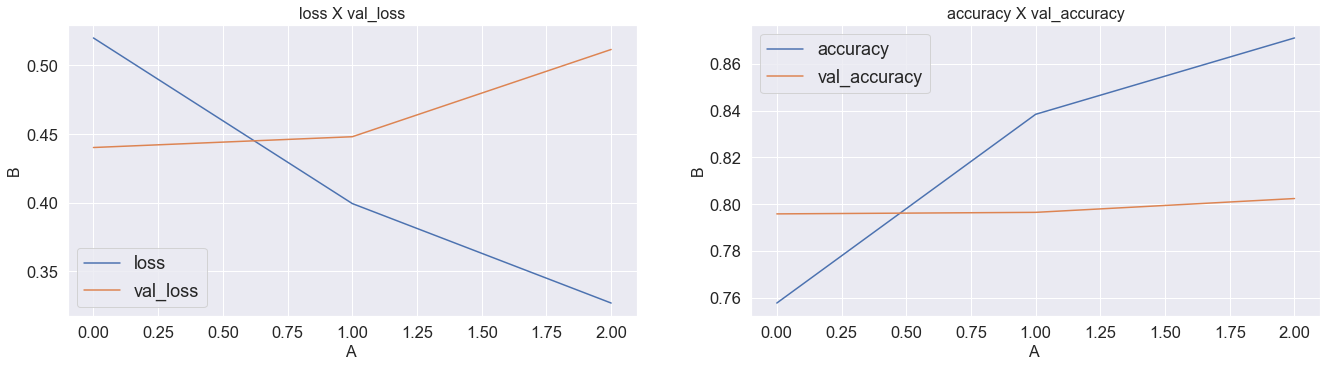

In [76]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

### 5. 제출용 파일 만들기

In [167]:
sample_submission = pd.read_csv("D:/DataSet/Natural Language Processing with Disaster Tweets/sample_submission.csv")

In [169]:
 test_df = pd.read_csv("D:/DataSet/Natural Language Processing with Disaster Tweets/test.csv")

- test_df 전처리

In [170]:
test_df['text_clean'] = test_df['text'].apply(lambda x: remove_URL(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: remove_html(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: remove_emoji(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: remove_punct(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: correct_spellings(x))
test_df['text_clean'] = test_df['text_clean'].apply(lambda x: x.lower())
test_df.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [171]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
test_df['text_clean'] = test_df['text_clean'].apply(remove_stopwords)
test_df.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan


In [172]:
test_df['text_clean'] = test_df['text_clean'].apply(stemm_text)
test_df.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [173]:
test_df['text_clean'] =test_df['text_clean'].apply(word_tokenize)
test_df.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,"[happen, terribl, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","[heard, earthquak, differ, citi, stay, safe, e..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, gees, flee, across,..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalyps, light, spokan, wildfir]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kill, 28, china, taiwan]"


- test_df 벡터화

In [174]:
test_texts = test_df['text']
test_input = bert_encode(test_texts, 60)
test_input

(array([[  101,  2074,  3047, ...,     0,     0,     0],
        [  101,  2657,  2055, ...,     0,     0,     0],
        [  101,  2045,  2003, ...,     0,     0,     0],
        ...,
        [  101,  2665,  2240, ...,     0,     0,     0],
        [  101, 12669,  3314, ...,     0,     0,     0],
        [  101,  1001,  2103, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [175]:
test_pred = model.predict(test_input)

102/102 [==============================] - 22s 214ms/step


In [176]:
test_pred

array([[0.9661823 ],
       [0.97139466],
       [0.97688943],
       ...,
       [0.9955722 ],
       [0.9723352 ],
       [0.8649307 ]], dtype=float32)

In [177]:
sample_submission['target'] = test_pred.round().astype(int)
sample_submission.to_csv('bert_submission.csv', index=False)